
# Redes Bayesiana con pgmpy

La **Red Bayesiana** es una herramienta poderosa para modelar sistemas probabilísticos. En Python, podemos utilizar la biblioteca `pgmpy` para crear y trabajar con Redes Bayesianas. Dicha herramienta será utilizada en este fichero con el fin de realizar un experimiento para aprender sobre el funcionamiento de dichas redes con el uso de la librería haciendo un estudio sobre cómo influyen algunos indicadores económicos y demográficos sobre la tasa de crecimiento de la población en España.


Dentro de este fichero se harán uso de diferentes librerias, cada una de las cuales tendrá una función específica y de las que podemos destacar las siguientes clases utilizadas y su uso.

Creación de modelo: 
   - `BayesianNetwork`

Creación de inferencias:
   - `VariableElimination`
   - `BeliefPropagation`
   - `ApproxInference`
   - `BayesianModelSampling`

Estimador aplicado en el entrenamiento:
   - `BayesianEstimator`


In [20]:
# Importación de librerías necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination, ApproxInference, BeliefPropagation
from pgmpy.estimators import BayesianEstimator
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

from pandas import read_csv, DataFrame
import numpy as np
import pandas as pd

Para la creación de una red bayesiana es necesario disponer de un conjunto de nodos relacionados entre sí. El nombre de dichos nodos son guardados a través de variables para una mayor comodidad al uso de los mismos. Para que además la representación en las tablas tenga una mayor legelibilidad se aplicará el uso de acrónimos de los cuales se mostrará a continuación su trazabilidad para un mayor entendimiento de los mismos

- RTE: Porcentaje de personas mayores de 25 años con al menos la ESO
- RTU: Porcentaje de población urbana
- RTP: Tasa de paro
- INB: Ingreso nacional bruto
- PIB: Producto Interior Bruto
- GSE: Gasto educativo
- GSS: Gastos en salud
- RTF: Tasa de fertilidad
- RTM: Tasa de mortalidad
- MGN: Migracion neta
- RTC: Tasa de crecimiento de la población

In [21]:
# Definir constantes para los nodos de la red bayesiana
LV_EDU = "RTE"             # "% de personas mayores de 25 años con al menos la ESO"     # SE.SEC.CUAT.UP.ZS
LV_URB = "RTU"             # "Porcentaje de población urbana"                           # SP.URB.TOTL.IN.ZS
RT_PARO = "RTP"            # "Tasa de paro"                                             # SL.UEM.TOTL.ZS
INB = "INB"                # "Ingreso nacional bruto"                                   # NY.GNP.PCAP.CD
PIB = "PIB"                # "Producto Interior Bruto"                                  # NY.GDP.PCAP.KD.ZG
GASTO_EDUCATIVO = "GSE"    # "Gasto educativo"                                          # SE.XPD.TOTL.GD.ZS
GASTO_SALUD = "GSS"        # "Gastos en salud"                                          # SH.XPD.CHEX.PC.CD
RT_FERTILIDAD = "RTF"      # "Tasa de fertilidad"                                       # SP.DYN.TFRT.IN
RT_MORTALIDAD = "RTM"      # "Tasa de mortalidad"                         
MIGRACION_NETA = "MGN"     # "Migracion neta"                                           # SM.POP.NETM
RT_CRECIMIENTO = "RTC"     # "Tasa de crecimiento de la población"                      # SP.POP.GROW

## Introducción de nodos al modelo
La creación de una red bayesiana se hace a través de la librería __pgmpy__ con el uso de la clase __BayesianNetwork__. 

En ella es posible añadir nodos aplicando con los siguientes métodos:
- Si se quiere añadir solo un nodo se aplica el metodo `add_node(nodo)`  
- En caso de querer añadir varios nodos al mismo tiempo `add_nodes_from(iterable_de_nodos)`

A su vez, también es necesario añadir los enlaces entre los nodos, que de forma similar a la inclusión de nodos, se pueden hacer de dos formas diferentes:
- Aplicando el método `add_edge(origen, destino)` se añade un camino del nodo origen al nodo destino
- Aplicando el método `add_edges_from(iterable_de_tuplas(origen,destino))` se añaden todos los caminos referidos en las tuplas del iterable. 

Para la creación de enlaces se debe tener muy en cuenta el orden de origen y destino. Esto se debe a que una red bayesiana es en esencia un grafo acíclico dirigido, por lo que un camino que vaya de un nodo "A" a un nodo "B" no será el mismo que uno de un nodo "B" a un nodo "A". Además de ello, como el grafo debe de ser acíclico, antes de la inclusión de los caminos debemos de tener en cuenta que no se añada ninguno de forma que se cree algún ciclo.


In [22]:
# Se crea el objeto para el model 
model = BayesianNetwork()

# Añadimos todos los nodos
nodes = [
    RT_CRECIMIENTO, PIB, RT_PARO, GASTO_EDUCATIVO, GASTO_SALUD, INB, LV_URB, RT_FERTILIDAD, RT_MORTALIDAD,
    MIGRACION_NETA, LV_EDU
    ]

model.add_nodes_from(nodes)

#Creamos y añadimos los caminos
edges_RT_PARO = [
    (LV_EDU, RT_PARO), 
    (LV_URB, RT_PARO)
    ]
edges_PIB = [
    (RT_PARO, PIB), 
    (INB, PIB)
    ]
edges_RT_FERTILIDAD = [
    (GASTO_EDUCATIVO, RT_FERTILIDAD), 
    (GASTO_SALUD, RT_FERTILIDAD)
    ]
edges_RT_CRECIMIENTO = [
    (MIGRACION_NETA, RT_CRECIMIENTO),
    (RT_FERTILIDAD, RT_CRECIMIENTO), 
    (RT_MORTALIDAD, RT_CRECIMIENTO)
    ]

model.add_edges_from(edges_RT_PARO)
model.add_edges_from(edges_PIB)
model.add_edge(PIB, GASTO_EDUCATIVO)
model.add_edge(PIB, GASTO_SALUD)
model.add_edges_from(edges_RT_FERTILIDAD)
model.add_edge(GASTO_SALUD, RT_MORTALIDAD)
model.add_edges_from(edges_RT_CRECIMIENTO)

Dado que el conjunto de datos puede ser escogido dentro de un determinado rango de años, se hará uso de una función auxiliar para dicha selección, donde se escogeran los datos relacionados a dicho conjunto de datos. A su vez, dichos datos serán obtenidos de un csv ya proporcionado, el cuál ha sido obtenido a través de la página de [Data Bank](https://databank.worldbank.org/reports.aspx?source=2&type=metadata). La lectura de datos se aplicará usando la funcón `read_csv(filepath_or_buffer, delimiter)` proporcionada por pandas, usando como __delimitador__ del archivo el carácter ';'

In [23]:
years = {"min" : 1975, "max" : 2022}
df_raw = read_csv("./csv/data.csv", delimiter=';')
def choice_by_years(dt: DataFrame, min: int = None, max: int = None):
    return DataFrame(dt[[col for col in dt.columns 
                                  if col == "Year" or 
                                  (min == None and max == None) or
                                  (int(col) >= min and int(col) <= max) or
                                  (min == None and int(col) <= max) or
                                  (int(col) >= min and max == None)]])
df_raw_growth = choice_by_years(df_raw, years["min"], years["max"])
print("There are " + str(df_raw_growth.shape[0]) + " indicators in the dataframe.")
df_raw_growth.head()

There are 11 indicators in the dataframe.


,Year,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Population growth (annual %),1.081294,1.056852,1.029132,0.962877,0.881585,0.802964,0.710878,0.600390,0.487183,...,-0.327669,-0.298951,-0.077589,0.084430,0.234588,0.437983,0.717716,0.488502,0.105799,0.761702
1,GDP per capita growth (annual %),-0.539097,2.217773,1.785657,0.490728,-0.836528,1.391315,-0.839887,0.640409,1.275515,...,-1.079741,1.699353,3.919117,2.950816,2.734475,1.837460,1.254632,-11.600189,6.290659,4.968051
2,"Unemployment, total (% of total labor force) (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.090000,24.440000,22.060000,19.640000,17.220000,15.250000,14.100000,15.530000,14.780000,12.920000
3,"Educational attainment, at least completed upp...",NaN,NaN,NaN,NaN,NaN,NaN,12.833750,NaN,NaN,...,47.237251,47.863049,48.649059,49.865326,50.416988,52.195572,53.256748,54.987942,55.349281,NaN
4,Current health expenditure per capita (current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2629.466797,2679.476563,2349.093750,2376.601074,2524.684814,2741.382568,2716.833496,2899.018799,3234.292969,NaN


In [24]:
df_growth = df_raw_growth.transpose().iloc[1:]
df_growth.columns = nodes
df_growth.head(10)

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1975,1.081294,-0.539097,NaN,NaN,NaN,3240.0,69.57,2.77,298192.0,1177.0,NaN
1976,1.056852,2.217773,NaN,NaN,NaN,3430.0,70.231,2.77,299007.0,4854.0,1.89939
1977,1.029132,1.785657,NaN,NaN,NaN,3640.0,70.883,2.65,294324.0,195.0,2.07717
1978,0.962877,0.490728,NaN,NaN,NaN,4040.0,71.527,2.54,296781.0,-1893.0,2.23073
1979,0.881585,-0.836528,NaN,NaN,NaN,5010.0,72.162,2.37,291213.0,-6124.0,2.33805
1980,0.802964,1.391315,NaN,NaN,NaN,6210.0,72.789,2.22,289344.0,15108.0,NaN
1981,0.710878,-0.839887,NaN,12.83375,NaN,6310.0,73.279,2.04,293386.0,-6044.0,NaN
1982,0.60039,0.640409,NaN,NaN,NaN,5680.0,73.515,1.94,286655.0,-16439.0,NaN
1983,0.487183,1.275515,NaN,NaN,NaN,4860.0,73.749,1.8,302569.0,-21369.0,NaN
1984,0.415256,1.362897,NaN,NaN,NaN,4580.0,73.982,1.73,299409.0,-18090.0,NaN


Una vez obtenidos los datos en un Dataframe, estos deberán ser __discretizados__ para su posible uso dentro de la red bayesianal. 

En este caso, se han creado dos funciones auxiliares para ello, la función `get_boundaries(tiers)` realiza el cálculo de los intervalos para la discretización de los datos en cada variable, mientras que la función `relabel(v, boundaries)` discretiza las variables haciendo uso del valor del dato y los intervalos posibles de dichas variables. 

En nuestro caso, realizamos una discretización en tres capas, siendo los posibles valores __1_ALTO__, __2_MEDIO__ y __3_BAJO__.

In [25]:
TIERS_NUM = 3

def relabel(v, boundaries):
    if v >= boundaries[0][0] and v <= boundaries[0][1]:
        return "3_BAJO"
    elif v >= boundaries[1][0] and v <= boundaries[1][1]:
        return "2_MEDIO" 
    elif v >= boundaries[2][0] and v <= boundaries[2][1]:
        return "1_ALTO" 
    else:
        return np.nan

def get_boundaries(tiers):
    prev_tier = tiers[0]
    boundaries = [(prev_tier[0], prev_tier[prev_tier.shape[0] - 1])]
    for index, tier in enumerate(tiers):
        if index != 0:
            boundaries.append((prev_tier[prev_tier.shape[0] - 1], tier[tier.shape[0] - 1]))
            prev_tier = tier
    return boundaries

new_columns = {}

for i, content in enumerate(df_growth.items()):
    (label, series) = content
    values = np.array([x for x in series.tolist() if not np.isnan(float(x))] , dtype=float)
    values = np.sort(values)
    if values.shape[0] < TIERS_NUM:
        print(f'Error: there are not enough data for label {label}')
        break
    boundaries = get_boundaries(tiers=np.array_split(values, TIERS_NUM))
    new_columns[label] = [relabel(float(value), boundaries) for value in series.tolist()]

df = DataFrame(data=new_columns)
df.columns = nodes
df.index = range(years["min"], years["max"] + 1)
df.head(10)

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1975,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1976,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,3_BAJO
1977,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,3_BAJO
1978,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1979,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1980,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1981,2_MEDIO,3_BAJO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1982,2_MEDIO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1983,2_MEDIO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1984,2_MEDIO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN


# APRENDIZAJE

En nuestro caso el aprendizaje será realizado antes de la inferencia del modelo. Esta decisión ha sido decida debido a la elección de tomar como ejemplo el siguente código [Tutorial Notebook](https://pgmpy.org/detailed_notebooks/11.%20A%20Bayesian%20Network%20to%20model%20the%20influence%20of%20energy%20consumption%20on%20greenhouse%20gases%20in%20Italy.html). Esto a permitido además de que la toma de las probabilidades condicionadas (CPDs) puedan ser calculadas directamente por el propio modelo, además de que se realiza una transformación de dichas probabilidades a csv para una mayor facilidad de visualización de las mismas.

Para el entrenamiento del modelo se utilizan todos los datos obtenidos previamente del csv de datos. A su vez, en dicho entrenamiento se puede utilizar el estimador por defecto __MaximumLikelihoodEstimator__. Sin embargo, nosotros usaremos como estimador el  __BayesianEstimator__. Dicho estimador permite aprovechar una distribución previa conocida de datos.
En el proceso de aprendizaje, utilizando __BDeu__, se __generan N muestras uniformes__ para cada variable para calcular los pseudoconteos (en nuestro caso N=10), por lo tanto, las probabilidades estimadas en CPT son más conservadoras que las obtenidas a través de MLE (es decir, probabilidades cercanas a 1 o 0 se suavizan).

In [26]:
model.cpds = []
model.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10)

print(f'Check model: {model.check_model()}\n')

for cpd in model.get_cpds():
    cpd.to_csv(filename=f'./csv/cpds/{cpd.variable}.csv')

Check model: True



# INFERENCIA

La inferencia es referida al cálculo de probabilidades condicionadas de una variable teniendo en cuenta las relaciones existentes hacia la misma. Dentro de la misma podemos diferenciar dos tipos de inferencia: __exacta__ y __aproximada__.

Por ejemplo, en nuestro caso la variable relacionada al crecimiento de la población tiene relaciones desde la migración neta, ratio de fertilidad y ratio de mortalidad. Por consecuencia, para el calculo de la inferencia de nuestra variable objetivo se han de tener en cuenta las probabilidades de las tres variables mencionadas.

Al momento de realizar el calculo de las inferencias se le ha de pasar fundamentalmente dos parámetros:
- __variables__: listado de variables objetivo a las que se le desea realizar predicciones por inferencia.
- __evidence__: las evidencias relacionadas ha dichas variables objetivo junto con su valor asociado.

En ese caso, hemos marcado la variable objetivo como la tasa de crecimiento y dentro de las evidencias hemos marcado la migración neta y el rato de mortalidad con 3_BAJO mientras que al ratio de fertilidad lo hemos marcado con 1_ALTO.

In [27]:
var = [RT_CRECIMIENTO]
ev = { 
    MIGRACION_NETA: "3_BAJO",
    RT_FERTILIDAD: "1_ALTO",
    RT_MORTALIDAD: "3_BAJO"
}

## INFERENCIA EXACTA

El calculo de la __inferencia exacta__ proporciona resultados __precisos__ y __no dependientes de aproximaciones__ numéricas, sin embargo, esto produce un __mayor coste computacional__.

A continuación se van a probar dos inferencias exactas aplicando las clases `VariableElimination` y `BeliefPropagation`, utilizando los métodos `query(variables, evidence)` respectivas de cada una para la realización de las predicciones.

In [28]:
# Variable Elimination

inference_1 = VariableElimination(model)
result_1 = inference_1.query(
    variables=var, 
    evidence=ev
    )

print(result_1)

+--------------+------------+
| RTC          |   phi(RTC) |
+==============+============+
| RTC(1_ALTO)  |     0.1868 |
+--------------+------------+
| RTC(2_MEDIO) |     0.3626 |
+--------------+------------+
| RTC(3_BAJO)  |     0.4506 |
+--------------+------------+


In [29]:
# Belief Propagation
inference_2 = BeliefPropagation(model) 
result_2 = inference_2.query(
    variables=var, 
    evidence=ev
    )

print(result_2)

+--------------+------------+
| RTC          |   phi(RTC) |
+==============+============+
| RTC(1_ALTO)  |     0.1868 |
+--------------+------------+
| RTC(2_MEDIO) |     0.3626 |
+--------------+------------+
| RTC(3_BAJO)  |     0.4506 |
+--------------+------------+


## INFERENCIA APROXIMADA

El calculo de la __inferencia aproximada__ permiten obtener soluciones aproximadas que son suficientemente precisas para propósitos prácticos.

En estos casos, además, se ha añadido la variable `size` para señalar el número de ejemplos que se generarán durante la predicción.

A continuación se van a probar dos inferencias aproximadas aplicando las clases `BayesianModelSampling`, donde se aplicará el método `rejection_sample(size, evidence)` para la predicción, y `ApproxInference`, donde se aplicará el método `query(varibles, evidence, n_samples)`

In [30]:
size=1000

El uso de la clase `BayesianModelSampling` varia algo más sobre el resto de clases, ya que en este caso las evidencias no pueden ser introducidas como un diccionario con pares (nodo, valor), sino que debe de crearse un listado de __State__. Para ello se realizará un parseo como se muestra a continuación

In [31]:
ev_2 = []

for key, value in ev.items():
        state = State(key, value)
        ev_2.append(state)

Otra diferencia observable es que en este caso la variable objetivo no se introduce dentro de las variables de la función, sino que después se le tiene que aplicar el método `get(variable)` para obtener los respectivos datos y posteriormente le hemos aplicado el método `value_counts(normalize=True, sort=True)` para obtener dichos datos con un orden fijo normalizados entre 0 y 1.

In [32]:
# Bayesian Model Sampling
inference_3 = BayesianModelSampling(model)
result_3 = inference_3.rejection_sample(
        size=size, 
        evidence=ev_2
        ).get(RT_CRECIMIENTO).value_counts(normalize=True, sort=True)

print("#"*50)
print(result_3)
print("#"*50)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
 91%|█████████▏| 913/1000 [00:02<00:00, 445.17it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the Dat

##################################################
RTC
3_BAJO     0.470
2_MEDIO    0.359
1_ALTO     0.171
Name: proportion, dtype: float64
##################################################


In [33]:
# Approximate Inference Using Sampling

inference_4 = ApproxInference(model)
result_4 = inference_4.query(
    variables=var,
    evidence=ev, 
    n_samples=size
    )

print(result_4)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
 96%|█████████▋| 965/1000 [00:00<00:00, 1293.57it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the Da

+--------------+------------+
| RTC          |   phi(RTC) |
+==============+============+
| RTC(1_ALTO)  |     0.1690 |
+--------------+------------+
| RTC(2_MEDIO) |     0.3700 |
+--------------+------------+
| RTC(3_BAJO)  |     0.4610 |
+--------------+------------+


A continuación podemos ver una comparación entre los resultados que hemos obtenido en las inferencias exactas y aproximadas respectivamente, además de un ejemplo de la observación del **error absoluto** calculado entre los valores reales y los datos obtenidos por las inferencias aproximadas.

Como conclusión se puede visualizar que las inferencias exactas llegan a dar resultados equivalentes, mientras que de entre las inferencias aproximadas, la más optima parece ser la de **_Aproximación por uso de muestras_**, ya que la otra inferencia usada llega a causar casi el doble de error.

### __Valores reales__

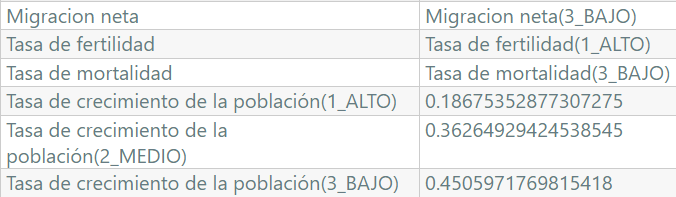

### __Variable Elimination && Belief Propagation__

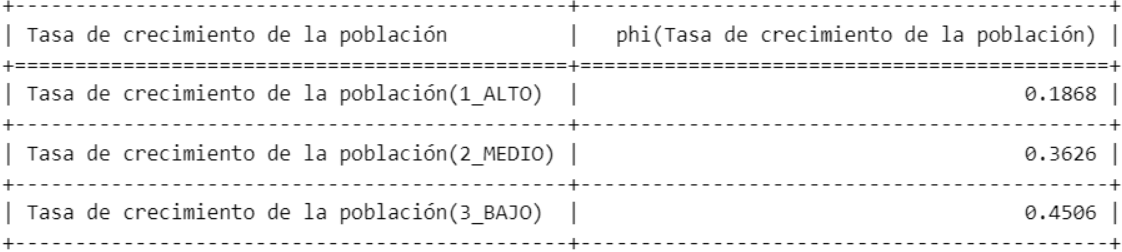

### __Bayesian Model Sampling__

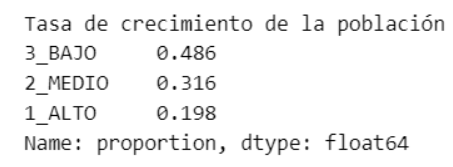

<span style="color: red;">__Error: 0.0932__</span>

### __Approximate Inference Using Sampling__

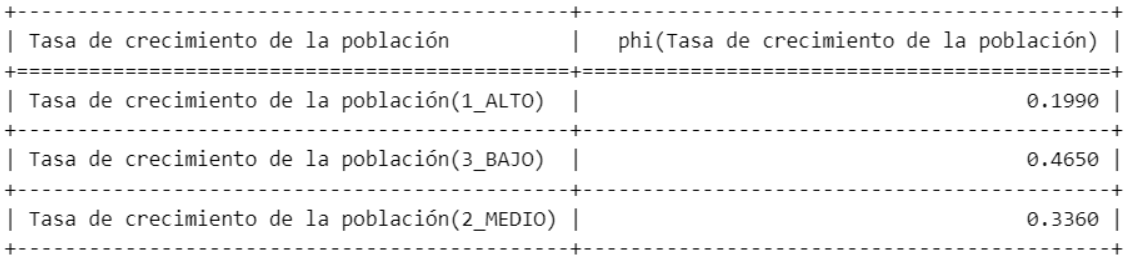

<span style="color: red;">__Error: 0.0532__</span>

# PRUEBA PARA RANGO MENOR

Por último, vamos a estimar el modelo con un conjunto menor de datos aplicandolos al modelo entrenado. Para ello, realizaremos dichas pruebas sobre una inferencia exacta, `VariableElimination`, y sobre la inferencia aproximada que ha dado mejor resultado anteriormente, `ApproxInference`.

Para la lectura de dichos datos se realizará un procedimiento similar al anterior mencionado, siendo la única diferencia que los datos obtenidos serán desde 1980 a 2005.

In [34]:
years_2 = {"min" : 1980, "max" : 2005}
df_raw = read_csv("./csv/data.csv", delimiter=';')
df_raw_growth = choice_by_years(df_raw, years_2["min"], years_2["max"])
print("There are " + str(df_raw_growth.shape[0]) + " indicators in the dataframe.")
df_raw_growth.head()

There are 11 indicators in the dataframe.


,Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
0,Population growth (annual %),0.802964,0.710878,0.600390,0.487183,0.415256,0.362366,0.298782,0.259329,0.212065,...,0.416516,0.419120,0.413847,0.405323,0.447137,0.694068,1.412595,1.808454,1.725466,1.689349
1,GDP per capita growth (annual %),1.391315,-0.839887,0.640409,1.275515,1.362897,1.951329,2.945279,5.273763,4.871692,...,2.233853,3.268767,3.961965,4.067886,4.776401,3.214135,1.289977,1.136294,1.358649,1.915746
2,"Unemployment, total (% of total labor force) (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.140000,20.700000,18.670000,15.480000,13.790000,10.350000,11.150000,11.280000,11.090000,9.150000
3,"Educational attainment, at least completed upp...",NaN,12.833750,NaN,NaN,NaN,15.700000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.261650,40.389420,41.441830
4,Current health expenditure per capita (current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1005.283997,1045.050659,1174.579346,1640.917725,1924.270874,2060.321533


In [35]:
df_growth = df_raw_growth.transpose().iloc[1:]
df_growth.columns = nodes
df_growth.head(10)

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1980,0.802964,1.391315,NaN,NaN,NaN,6210.0,72.789,2.22,289344.0,15108.0,NaN
1981,0.710878,-0.839887,NaN,12.83375,NaN,6310.0,73.279,2.04,293386.0,-6044.0,NaN
1982,0.60039,0.640409,NaN,NaN,NaN,5680.0,73.515,1.94,286655.0,-16439.0,NaN
1983,0.487183,1.275515,NaN,NaN,NaN,4860.0,73.749,1.8,302569.0,-21369.0,NaN
1984,0.415256,1.362897,NaN,NaN,NaN,4580.0,73.982,1.73,299409.0,-18090.0,NaN
1985,0.362366,1.951329,NaN,15.7,NaN,4550.0,74.213,1.64,312532.0,-17354.0,NaN
1986,0.298782,2.945279,NaN,NaN,NaN,5400.0,74.444,1.56,310413.0,-19462.0,NaN
1987,0.259329,5.273763,NaN,NaN,NaN,7110.0,74.673,1.49,310073.0,-22528.0,3.12818
1988,0.212065,4.871692,NaN,NaN,NaN,9410.0,74.9,1.45,319437.0,-24067.0,3.3283
1989,0.156776,4.662815,NaN,NaN,NaN,10700.0,75.126,1.4,324796.0,-31560.0,3.55178


In [36]:
new_columns = {}
for i, content in enumerate(df_growth.items()):
    (label, series) = content
    values = np.array([x for x in series.tolist() if not np.isnan(float(x))] , dtype=float)
    values = np.sort(values)
    if values.shape[0] < TIERS_NUM:
        print(f'Error: there are not enough data for label {label}')
        break
    boundaries = get_boundaries(tiers=np.array_split(values, TIERS_NUM))
    new_columns[label] = [relabel(float(value), boundaries) for value in series.tolist()]

data_test = DataFrame(data=new_columns)
data_test.columns = nodes
data_test.index = range(years_2["min"], years_2["max"] + 1)
data_test.head(10)

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1980,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1981,1_ALTO,3_BAJO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1982,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1983,2_MEDIO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1984,2_MEDIO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1985,3_BAJO,2_MEDIO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1986,3_BAJO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1987,3_BAJO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1988,3_BAJO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,2_MEDIO,3_BAJO,3_BAJO,3_BAJO
1989,3_BAJO,1_ALTO,NaN,NaN,NaN,2_MEDIO,2_MEDIO,2_MEDIO,2_MEDIO,3_BAJO,3_BAJO


Para realizar las predicciones serán usadas las siguientes funciones auxiliares, `predict(data)` para la predicción por inferencia exacta y `predict_approx(data)` para la predicción por inferencia aproximada. 

En ambos casos lo que se realiza es una predicción de los datos sobre la variable objetivo (RTC) para cada año y posteriormente se muestran por pantalla los primeros 10 datos predichos. 

La principal diferencia entre ambas funciones es que dependiendo de la inferencia se ha debido de usar un tipo diferentes de método, por una parte, para la inferencia exacta se ha hecho uso del método `map_query(variables, evidence)`, mientras que por parte de la inferencia aproximada se ha hecho uso del método `query(variables, evidence, n_samples)`.

In [37]:

inference_exact = VariableElimination(model)
inference_aprox = ApproxInference(model)

def predict(data):
    # Crear una copia del DataFrame de prueba para almacenar los resultados
    data_pred = data.copy()

    # Iterar sobre cada fila del DataFrame
    for index, row in data_pred.iterrows():
        ev = {var: row[var] for var in model.nodes() if pd.notnull(row[var]) and var in [RT_FERTILIDAD, RT_MORTALIDAD, MIGRACION_NETA]}
        predicted = inference_exact.map_query(variables=var, evidence=ev)
        # Actualizar el DataFrame con las predicciones
        for node, value in predicted.items():
            data_pred.at[index, node] = value

    return data_pred

def predict_approx(data):
    # Crear una copia del DataFrame de prueba para almacenar los resultados
    data_pred = data.copy()

    # Iterar sobre cada fila del DataFrame
    for index, row in data_pred.iterrows():
        ev = {var: row[var] for var in model.nodes() if pd.notnull(row[var]) and var in [RT_FERTILIDAD, RT_MORTALIDAD, MIGRACION_NETA]}
        query_result = inference_aprox.query(show_progress=False , variables=var, evidence=ev, n_samples=size)
        # Actualizar el DataFrame con las predicciones
        for node in query_result.variables:
            predicted_value = query_result.state_names[var[0]][query_result.values.argmax()]
            data_pred.at[index, node] = predicted_value

    return data_pred

In [38]:
# Hacer predicciones sobre el conjunto de datos de prueba
data_pred_exact = predict(data_test)
data_pred_exact.head(10)

0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]







0it [00:00, ?it/s]










0it [00:00, ?it/s]













0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]







0it [00:00, ?it/s]










0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1980,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1981,1_ALTO,3_BAJO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1982,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1983,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1984,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1985,3_BAJO,2_MEDIO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1986,3_BAJO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1987,3_BAJO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1988,1_ALTO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,2_MEDIO,3_BAJO,3_BAJO,3_BAJO
1989,3_BAJO,1_ALTO,NaN,NaN,NaN,2_MEDIO,2_MEDIO,2_MEDIO,2_MEDIO,3_BAJO,3_BAJO


In [39]:
data_pred_aprox = predict_approx(data_test)
data_pred_aprox.head(10)

c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\U

,RTC,PIB,RTP,GSE,GSS,INB,RTU,RTF,RTM,MGN,RTE
1980,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1981,1_ALTO,3_BAJO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1982,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1983,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1984,3_BAJO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1985,3_BAJO,2_MEDIO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1986,3_BAJO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1987,3_BAJO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1988,3_BAJO,1_ALTO,NaN,NaN,NaN,3_BAJO,3_BAJO,2_MEDIO,3_BAJO,3_BAJO,3_BAJO
1989,3_BAJO,1_ALTO,NaN,NaN,NaN,2_MEDIO,2_MEDIO,2_MEDIO,2_MEDIO,3_BAJO,3_BAJO


Dado este pequeño muestreo de los 10 primeros datos predichos para estas dos inferencias podemos ver que obtenemos predicciones similares. Estas a su vez podemos decir que son buenas predicciones ya que realizan en gran parte de ellas un acierto sobre las condiciones reales de ejemplo.